In [ ]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC #LinearSVC should scale better to a higher number of samples than SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, LSTM, SpatialDropout1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Bidirectional,GRU,Input, Dense, Activation, RepeatVector, Dropout, Concatenate

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            # print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print("Error: ",e)
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertModel
from transformers import RobertaTokenizer, TFRobertaModel
from transformers import XLNetTokenizer, TFXLNetModel
from transformers import AutoTokenizer, TFXLNetModel

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from mlxtend.plotting import plot_confusion_matrix

from scipy.stats import pearsonr

import joblib

import numpy as np
import pickle

pd.set_option('display.max_colwidth', 50)


In [2]:
def check(df):
    l=[]
    columns=df.columns
    for col in columns:
        dtypes=df[col].dtypes
        nunique=df[col].nunique()
        sum_null=df[col].isnull().sum()
        l.append([col,dtypes,nunique,sum_null])
    df_check=pd.DataFrame(l)
    df_check.columns=['column','dtypes','nunique','sum_null']
    return df_check 

In [3]:
def plot_train_val_loss_acc(history):
    # plot learning curves
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # plot validation curves
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [4]:
# Load data from CSV file
import pandas as pd
df = pd.read_csv('Final_dataset_portuguese.csv')#.sample(10000).reset_index(drop='index')
df.head()

,Text,Source,URL,Label
0,PJ em operação internacional de tráfico de dro...,DN,https://www.dn.pt/sociedade/pj-em-operacao-int...,1
1,O texto foi criado - numa universidade da Repú...,NaN,https://poligrafo.sapo.pt/fact-check/fact-chec...,1
2,Nunca pague multas por conduzir sem carta ou s...,Contas Poupança,https://arquivo.pt/wayback/20200626170105mp_/h...,0
3,"Depois de António Guterres, uma estátua de D. ...",redes sociais,https://poligrafo.sapo.pt/fact-check/fact-chec...,0
4,"O MAR, uma droga gratuita que cura pelo menos ...",Coruja,https://arquivo.pt/wayback/20181012145922mp_/h...,0


In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras import layers

X = df['Text']
y = df['Label']

#split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42)

#define Keras Tokenizer
tok = Tokenizer()
tok.fit_on_texts(X_train)

#return sequences
sequences = tok.texts_to_sequences(X_train)
test_sequences = tok.texts_to_sequences(X_test)

#print size of the vocabulary
print(f'Train vocabulary size: {len(tok.word_index)}')

#maximum sequence length (512 to prevent memory issues and speed up computation)
MAX_LEN = 512

#padded sequences
X_train_seq = pad_sequences(sequences,maxlen=MAX_LEN)
X_test_seq = pad_sequences(test_sequences,maxlen=MAX_LEN)

X_train_seq.shape[1]

Train vocabulary size: 184636


512

Simple DNN Model

In [6]:
# # Step 1: Load and preprocess your dataset (replace 'df' and 'labels' with your actual data)
# # For this example, let's assume you have a DataFrame 'df' with a 'text' column and a 'label' column (0 for fake, 1 for real).
# X = df['Text']
# y = df['Label']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Step 2: Tokenize the text data
# #max_words = 10000  # Maximum number of words to keep in the vocabulary
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(X_train)

# # Convert text to sequences
# X_train_seq = tokenizer.texts_to_sequences(X_train)
# X_test_seq = tokenizer.texts_to_sequences(X_test)

# # Pad sequences to ensure consistent input shape
# max_sequence_length = 100  # Choose an appropriate sequence length
# X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
# X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

In [6]:
# Step 3: Build and train the DNN model
model = Sequential()
model.add(Embedding(input_dim = len(tok.word_index), output_dim=128, input_length=MAX_LEN))#model.add(Embedding(input_dim = len(tok.word_index), output_dim=128, input_length=max_sequence_length))
model.add(Flatten())  # You can also use LSTM or other recurrent layers here
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_seq,#X_train_padded,
          y_train,
          epochs=20,
          batch_size=64,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)])

Epoch 1/20
593/593 [==============================] - 21s 32ms/step - loss: 0.2718 - accuracy: 0.8803 - val_loss: 0.2078 - val_accuracy: 0.9166
Epoch 2/20
593/593 [==============================] - 20s 33ms/step - loss: 0.0291 - accuracy: 0.9908 - val_loss: 0.2715 - val_accuracy: 0.9093
Epoch 3/20
593/593 [==============================] - 20s 33ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.3179 - val_accuracy: 0.9098
Epoch 4/20
593/593 [==============================] - 20s 33ms/step - loss: 2.8090e-04 - accuracy: 1.0000 - val_loss: 0.3528 - val_accuracy: 0.9103


  1/495 [..............................] - ETA: 8s - loss: 0.2428 - accuracy: 0.8750

495/495 [==============================] - 1s 3ms/step - loss: 0.2048 - accuracy: 0.9178
Test Loss: 0.20479364693164825
Test Accuracy: 0.9178315997123718


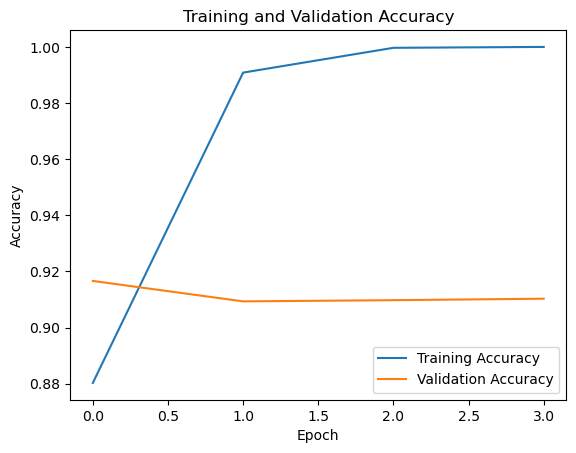

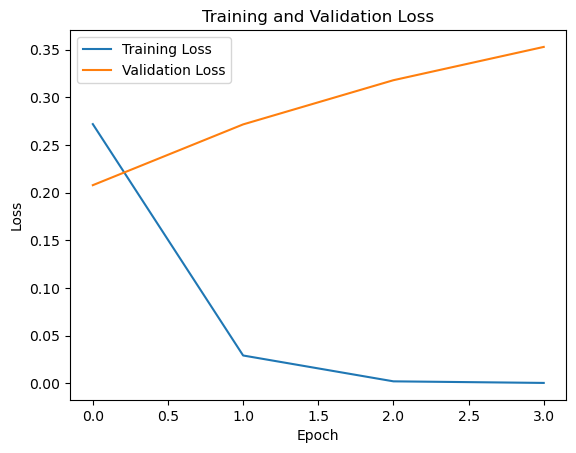

In [7]:
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_train_val_loss_acc(history)

In [8]:
# Step 4: Model Evaluation
y_pred = model.predict(X_test_seq)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7880
           1       0.94      0.90      0.92      7929

    accuracy                           0.92     15809
   macro avg       0.92      0.92      0.92     15809
weighted avg       0.92      0.92      0.92     15809



CNN Simple

In [ ]:
# Step 3: Build and train the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tok.word_index), output_dim=128, input_length=MAX_LEN))
model.add(Conv1D(128, 5, activation='relu'))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_seq,
          y_train,
          epochs=20,
          batch_size=64,
          validation_split=0.2,
          callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# Step 4: Model Evaluation
y_pred = model.predict(X_test_seq)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary labels

# Print classification report
report = classification_report(y_test, y_pred)
print(report)

Epoch 1/20
593/593 [==============================] - 32s 47ms/step - loss: 0.2673 - accuracy: 0.8817 - val_loss: 0.1956 - val_accuracy: 0.9184
Epoch 2/20
593/593 [==============================] - 27s 45ms/step - loss: 0.0829 - accuracy: 0.9698 - val_loss: 0.2282 - val_accuracy: 0.9215
Epoch 3/20
593/593 [==============================] - 27s 45ms/step - loss: 0.0209 - accuracy: 0.9926 - val_loss: 0.3276 - val_accuracy: 0.9169
Epoch 4/20
593/593 [==============================] - 27s 45ms/step - loss: 0.0078 - accuracy: 0.9972 - val_loss: 0.4923 - val_accuracy: 0.9077
Epoch 5/20
593/593 [==============================] - 27s 45ms/step - loss: 0.0074 - accuracy: 0.9971 - val_loss: 0.5519 - val_accuracy: 0.9140
              precision    recall  f1-score   support

           0       0.93      0.90      0.92      7880
           1       0.91      0.94      0.92      7929

    accuracy                           0.92     15809
   macro avg       0.92      0.92      0.92     15809
weighted

Simple LSTM Model

In [7]:
# Define the model
model = tf.keras.Sequential([
    Input(name='inputs', shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_seq,
                    y_train,
                    epochs=20,
                    validation_split=0.2,
                    batch_size=64,
                    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)])
                    

Epoch 1/20
593/593 [==============================] - 92s 148ms/step - loss: 0.3944 - accuracy: 0.8075 - val_loss: 0.2327 - val_accuracy: 0.9091
Epoch 2/20
593/593 [==============================] - 82s 139ms/step - loss: 0.1592 - accuracy: 0.9425 - val_loss: 0.2097 - val_accuracy: 0.9172
Epoch 3/20
593/593 [==============================] - 86s 145ms/step - loss: 0.0861 - accuracy: 0.9710 - val_loss: 0.2301 - val_accuracy: 0.9157
Epoch 4/20
593/593 [==============================] - 84s 142ms/step - loss: 0.0464 - accuracy: 0.9861 - val_loss: 0.3002 - val_accuracy: 0.9093
Epoch 5/20
593/593 [==============================] - 88s 148ms/step - loss: 0.0375 - accuracy: 0.9885 - val_loss: 0.3601 - val_accuracy: 0.9129


495/495 [==============================] - 22s 44ms/step - loss: 0.2014 - accuracy: 0.9212
Test Loss: 0.20138461887836456
Test Accuracy: 0.9212473630905151


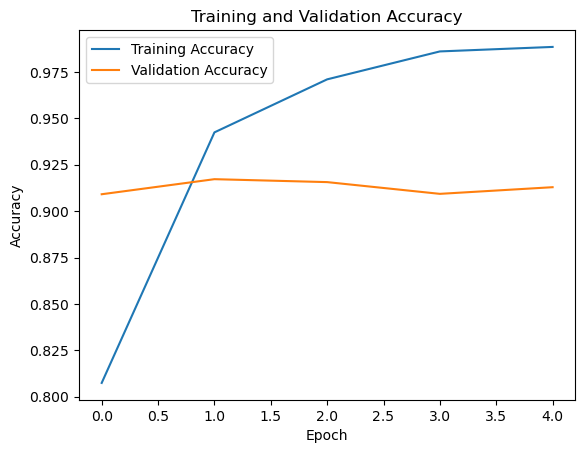

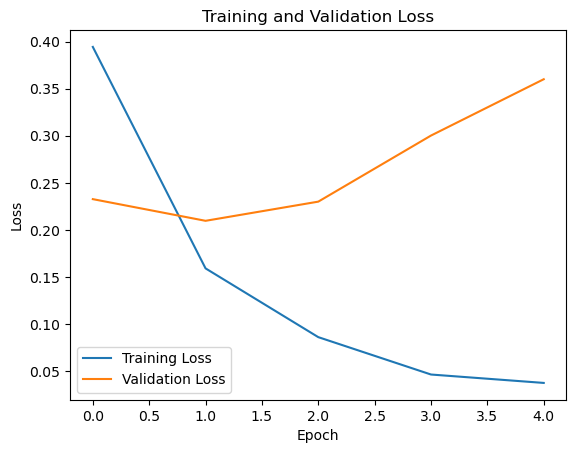

In [8]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plot_train_val_loss_acc(history)

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7880
           1       0.92      0.93      0.92      7929

    accuracy                           0.92     15809
   macro avg       0.92      0.92      0.92     15809
weighted avg       0.92      0.92      0.92     15809



(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

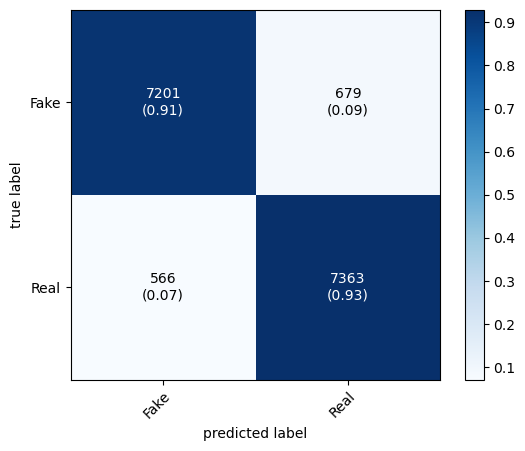

In [9]:
## print classification report
y_hat = model.predict(X_test_seq)
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

conf_mat = confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])

Simple Bi-LSTM Model

Epoch 1/20
593/593 [==============================] - 162s 264ms/step - loss: 0.4008 - accuracy: 0.8103 - val_loss: 0.2484 - val_accuracy: 0.9008
Epoch 2/20
593/593 [==============================] - 155s 262ms/step - loss: 0.1680 - accuracy: 0.9385 - val_loss: 0.2123 - val_accuracy: 0.9187
Epoch 3/20
593/593 [==============================] - 153s 258ms/step - loss: 0.0820 - accuracy: 0.9732 - val_loss: 0.2405 - val_accuracy: 0.9083
Epoch 4/20
593/593 [==============================] - 152s 257ms/step - loss: 0.0411 - accuracy: 0.9880 - val_loss: 0.2776 - val_accuracy: 0.9199
Epoch 5/20
593/593 [==============================] - 149s 251ms/step - loss: 0.0270 - accuracy: 0.9927 - val_loss: 0.3834 - val_accuracy: 0.9045
Epoch 6/20
593/593 [==============================] - 149s 251ms/step - loss: 0.0176 - accuracy: 0.9949 - val_loss: 0.3410 - val_accuracy: 0.9133
Epoch 7/20
593/593 [==============================] - 148s 250ms/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.4308 -

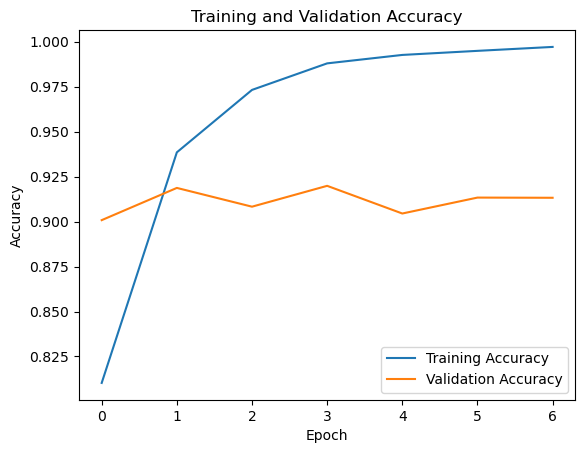

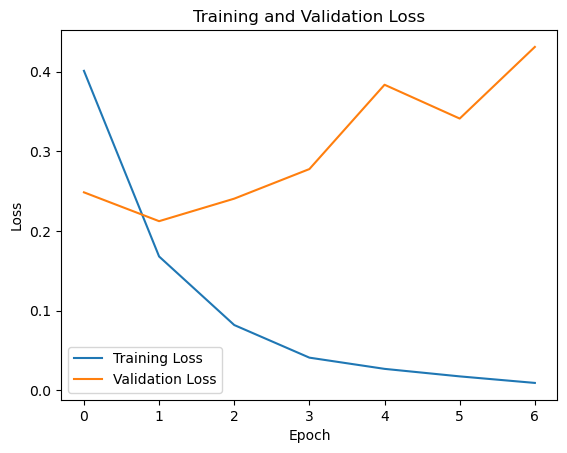

In [6]:
#define the model
model = tf.keras.Sequential([
    Input(name='inputs',shape=[MAX_LEN]),
    Embedding(len(tok.word_index), 128),
    Bidirectional(tf.keras.layers.LSTM(128,  return_sequences=True)),
    Bidirectional(tf.keras.layers.LSTM(64)),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

#compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

#model summary
# model.summary()

#Fit the model
history = model.fit(X_train_seq,
                    y_train,
                    epochs=20,
                    validation_split = 0.2,
                    batch_size = 64,
                    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)])

# plot learning curves
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# plot validation curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

495/495 [==============================] - 40s 80ms/step - loss: 0.2689 - accuracy: 0.9215
Test Loss: 0.26894548535346985
Test Accuracy: 0.9215003848075867
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      7880
           1       0.91      0.93      0.92      7929

    accuracy                           0.92     15809
   macro avg       0.92      0.92      0.92     15809
weighted avg       0.92      0.92      0.92     15809



(<Figure size 640x480 with 2 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

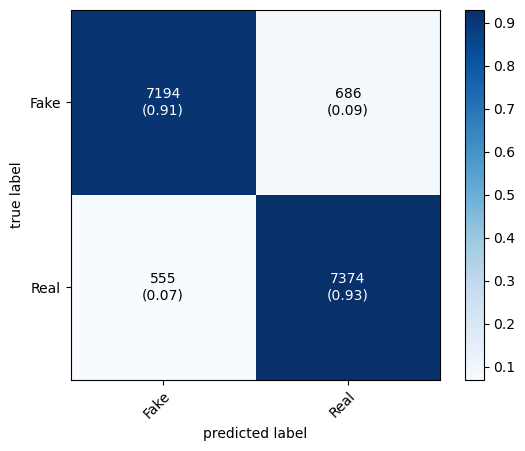

In [7]:
from mlxtend.plotting import plot_confusion_matrix

#Evaluate the model
test_loss, test_acc = model.evaluate(X_test_seq, y_test)
y_hat = model.predict(X_test_seq)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

## print classification report
print(classification_report(y_test, np.where(y_hat >= 0.5, 1, 0)))

conf_mat = confusion_matrix(y_test, np.where(y_hat >= 0.5, 1, 0))
plot_confusion_matrix(conf_mat,
                    show_normed=True, colorbar=True,
                    class_names=['Fake', 'Real'])

BERT (with only text)

In [5]:
# Split data into train and test sets
X = df['Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Load tokenized data
# with open('X_train_tokenized_BERT_uncased.pkl', 'rb') as f:
#     X_train_tokenized = pickle.load(f)

# with open('X_test_tokenized_BERT_uncased.pkl', 'rb') as f:
#     X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained BERT model
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/20
317/317 [==============================] - 444s 1s/step - loss: 1.1137 - accuracy: 0.7663 - val_loss: 0.5745 - val_accuracy: 0.8193
Epoch 2/20
317/317 [==============================] - 432s 1s/step - loss: 0.5071 - accuracy: 0.8294 - val_loss: 0.6286 - val_accuracy: 0.7847
Epoch 3/20
317/317 [==============================] - 431s 1s/step - loss: 0.3301 - accuracy: 0.8679 - val_loss: 0.3725 - val_accuracy: 0.8452
Epoch 4/20
317/317 [==============================] - 426s 1s/step - loss: 0.2423 - accuracy: 0.8982 - val_loss: 0.3769 - val_accuracy: 0.8459
Epoch 5/20
317/317 [==============================] - 426s 1s/step - loss: 0.2250 - accuracy: 0.9055 - val_loss: 0.4393 - val_accuracy: 0.8281
Epoch 6/20
317/317 [==============================] - 427s 1s/step - loss: 0.2227 - accuracy: 0.9080 - val_loss: 0.5870 - val_accuracy: 0.7868
Epoch 7/20
99/99 [==============================] - 98s 986ms/step - loss: 0.3555 - accuracy: 0.8566
Test loss: 0.355, Test accuracy: 0.857


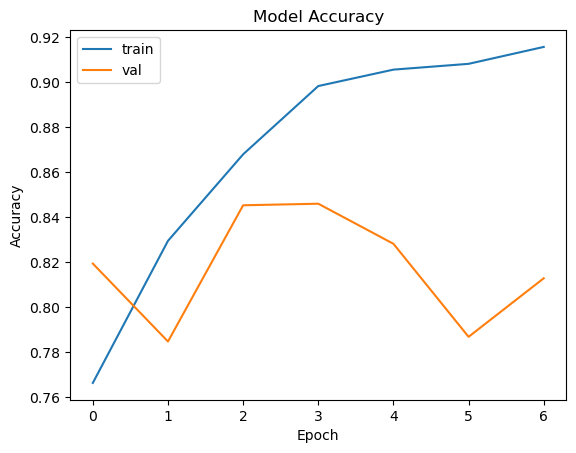

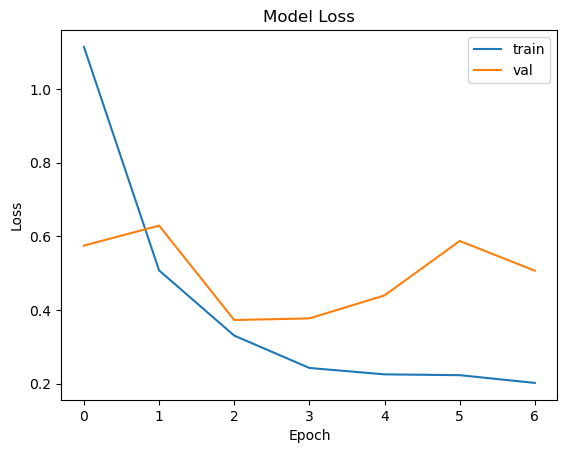

In [7]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=128,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      6285
           1       0.87      0.84      0.85      6363

    accuracy                           0.86     12648
   macro avg       0.86      0.86      0.86     12648
weighted avg       0.86      0.86      0.86     12648



RoBERTa with only text

In [6]:
# Split data into train and test sets
X = df['Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# Save tokenized data
# with open('X_train_tokenized_roBERTa_base.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

# with open('X_test_tokenized_roBERTa_base.pkl', 'wb') as f:
#    pickle.dump(X_test_tokenized, f)

# Load tokenized data
# with open('X_train_tokenized_roBERTa_base.pkl', 'rb') as f:
#     X_train_tokenized = pickle.load(f)

# with open('X_test_tokenized_roBERTa_base.pkl', 'rb') as f:
#     X_test_tokenized = pickle.load(f)

In [7]:
# Load the pre-trained BERT model
roberta_model = TFBertModel.from_pretrained('roberta-base')

# Freeze the pre-trained layers
for layer in roberta_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = roberta_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some layers from the model checkpoint at roberta-base were not used when initializing TFBertModel: ['lm_head', 'roberta']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['bert']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20
317/317 [==============================] - 446s 1s/step - loss: 1.5856 - accuracy: 0.4991 - val_loss: 0.6931 - val_accuracy: 0.4998
Epoch 2/20
317/317 [==============================] - 434s 1s/step - loss: 0.6932 - accuracy: 0.4992 - val_loss: 0.6932 - val_accuracy: 0.5002
Epoch 3/20
317/317 [==============================] - 433s 1s/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 4/20
317/317 [==============================] - 433s 1s/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.5002
Epoch 5/20
99/99 [==============================] - 102s 1s/step - loss: 0.6931 - accuracy: 0.5031
Test loss: 0.693, Test accuracy: 0.503


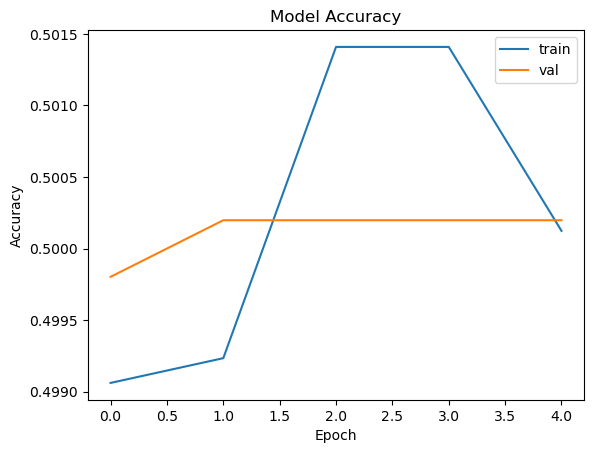

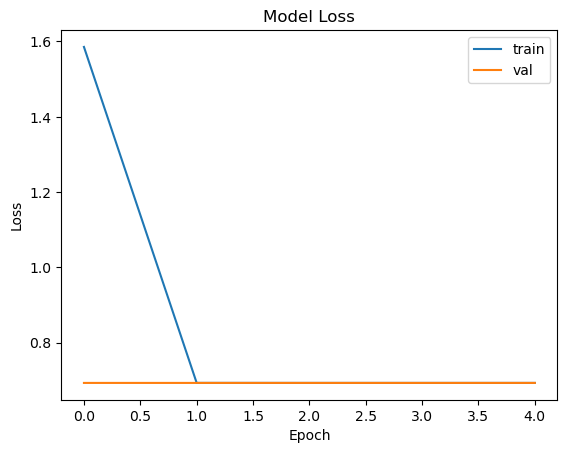

In [8]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=128,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      6285
           1       0.50      1.00      0.67      6363

    accuracy                           0.50     12648
   macro avg       0.25      0.50      0.33     12648
weighted avg       0.25      0.50      0.34     12648



c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

XLNET (with only text)

In [5]:
# Split data into train and test sets
X = df['Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the BERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("xlnet-base-cased")

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# # Save tokenized data
# with open('X_train_tokenized_XLNET_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

# with open('X_test_tokenized_XLNET_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_test_tokenized, f)

# Load tokenized data
# with open('X_train_tokenized_XLNET_base_cased.pkl', 'rb') as f:
#     X_train_tokenized = pickle.load(f)

# with open('X_train_tokenized_XLNET_base_cased.pkl', 'rb') as f:
#     X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained BERT model
model = TFXLNetModel.from_pretrained("xlnet-base-cased")

# Freeze the pre-trained layers
for layer in model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')
#input_masks = Input(shape=(128,), dtype=tf.int32, name='input_masks')
#input_segments = Input(shape=(128,), dtype=tf.int32, name='input_segments')

# Pass the input through the pre-trained BERT model
sequence_output = model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

Some layers from the model checkpoint at xlnet-base-cased were not used when initializing TFXLNetModel: ['lm_loss']
- This IS expected if you are initializing TFXLNetModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLNetModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLNetModel were initialized from the model checkpoint at xlnet-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLNetModel for predictions without further training.


In [7]:
# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split = 0.2,
    batch_size=16,
    epochs=20,
    callbacks=[EarlyStopping(monitor='val_accuracy',mode='max', patience=3, verbose=False,restore_best_weights=True)]
)

Epoch 1/20
2530/2530 [==============================] - 1169s 459ms/step - loss: 0.5959 - accuracy: 0.7680 - val_loss: 0.3819 - val_accuracy: 0.8214
Epoch 2/20
2530/2530 [==============================] - 1165s 461ms/step - loss: 0.3794 - accuracy: 0.8243 - val_loss: 0.3778 - val_accuracy: 0.8323
Epoch 3/20
2530/2530 [==============================] - 1166s 461ms/step - loss: 0.3428 - accuracy: 0.8408 - val_loss: 0.4996 - val_accuracy: 0.7960
Epoch 4/20
2530/2530 [==============================] - 1137s 449ms/step - loss: 0.3222 - accuracy: 0.8520 - val_loss: 0.3491 - val_accuracy: 0.8384
Epoch 5/20
2530/2530 [==============================] - 1151s 455ms/step - loss: 0.3036 - accuracy: 0.8613 - val_loss: 0.3454 - val_accuracy: 0.8426
Epoch 6/20
2530/2530 [==============================] - 1141s 451ms/step - loss: 0.2914 - accuracy: 0.8670 - val_loss: 0.3476 - val_accuracy: 0.8345
Epoch 7/20
2530/2530 [==============================] - 1128s 446ms/step - loss: 0.2799 - accuracy: 0.8738

791/791 [==============================] - 250s 316ms/step - loss: 0.3401 - accuracy: 0.8570
Test loss: 0.340, Test accuracy: 0.857


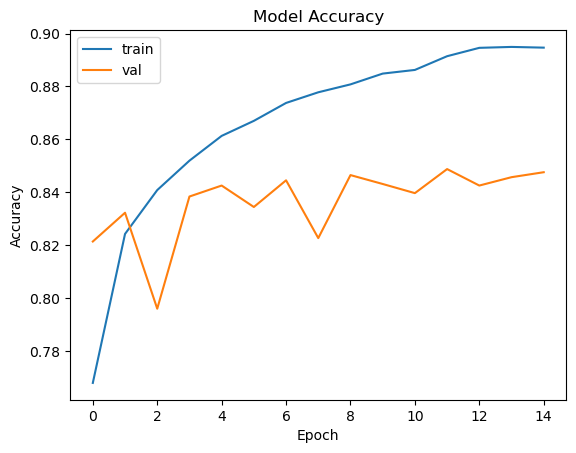

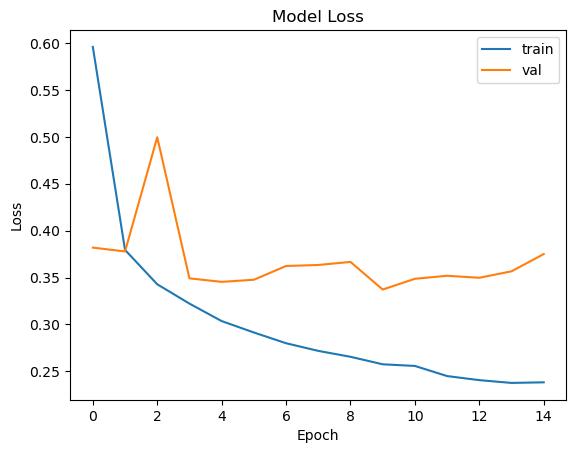

In [8]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=16)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [9]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86      6285
           1       0.86      0.86      0.86      6363

    accuracy                           0.86     12648
   macro avg       0.86      0.86      0.86     12648
weighted avg       0.86      0.86      0.86     12648



BERT Base Multilingual (text only)

In [5]:
# Split the dataset into train and test sets
X = df['Text'].values
y = df['Label'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the mBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# # Tokenize the input texts
# X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
# X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")

# # Save tokenized data
# with open('X_train_tokenized_BERTmulti_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_train_tokenized, f)

# with open('X_test_tokenized_BERTmulti_base_cased.pkl', 'wb') as f:
#     pickle.dump(X_test_tokenized, f)

# Load tokenized data
with open('X_train_tokenized_BERTmulti_base_cased.pkl', 'rb') as f:
    X_train_tokenized = pickle.load(f)

with open('X_test_tokenized_BERTmulti_base_cased.pkl', 'rb') as f:
    X_test_tokenized = pickle.load(f)

In [6]:
# Load the pre-trained mBERT model
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# Freeze the pre-trained layers
for layer in bert_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Pass the input through the pre-trained mBERT model
sequence_output = bert_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Downloading: 100%|██████████| 1.08G/1.08G [00:25<00:00, 43.2MB/s]
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ricardo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some layers from the model checkpoint at bert-base-multili

Epoch 1/20
317/317 [==============================] - 441s 1s/step - loss: 0.5658 - accuracy: 0.8345 - val_loss: 0.2830 - val_accuracy: 0.8800
Epoch 2/20
317/317 [==============================] - 426s 1s/step - loss: 0.2342 - accuracy: 0.9032 - val_loss: 0.2958 - val_accuracy: 0.8799
Epoch 3/20
317/317 [==============================] - 425s 1s/step - loss: 0.1772 - accuracy: 0.9279 - val_loss: 0.3256 - val_accuracy: 0.8643
Epoch 4/20
99/99 [==============================] - 99s 989ms/step - loss: 0.2793 - accuracy: 0.8827
Test loss: 0.279, Test accuracy: 0.883


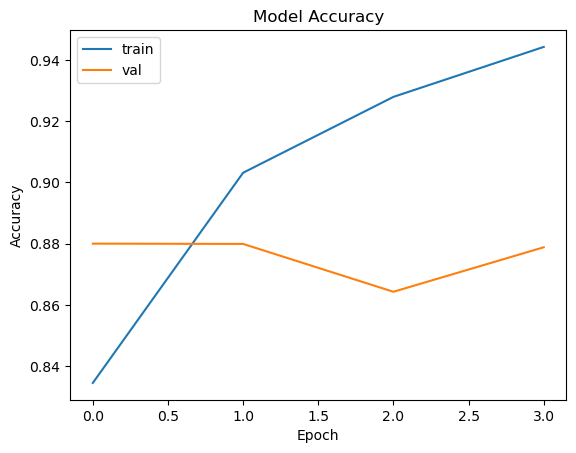

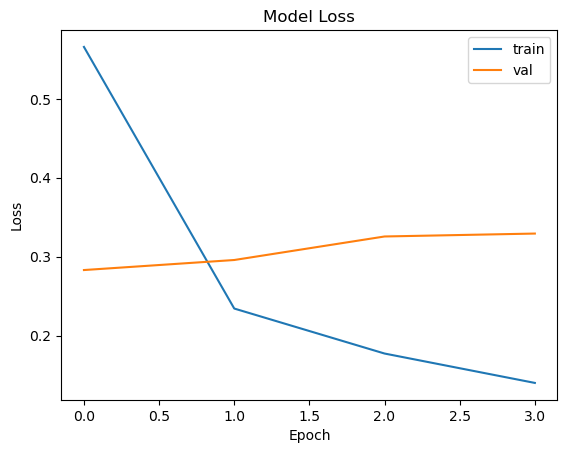

In [7]:
# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split=0.2,
    batch_size=128,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88      6285
           1       0.88      0.89      0.88      6363

    accuracy                           0.88     12648
   macro avg       0.88      0.88      0.88     12648
weighted avg       0.88      0.88      0.88     12648



XLM-R (text only)

In [5]:
from transformers import XLMRobertaTokenizer, TFXLMRobertaModel
X = df['Text'].values
y = df['Label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Load the XLM-R tokenizer
tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize the input texts
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors="tf")


Downloading: 100%|██████████| 5.07M/5.07M [00:00<00:00, 6.35MB/s]
c:\Users\Ricardo\anaconda3\envs\tf-gpy-backup15\lib\site-packages\huggingface_hub\file_download.py:123: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Ricardo\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Downloading: 100%|██████████| 615/615 [00:00<?, ?B/s] 


In [6]:
# Load the pre-trained XLM-R model
xlmr_model = TFXLMRobertaModel.from_pretrained('xlm-roberta-base')

# Freeze the pre-trained layers
for layer in xlmr_model.layers:
    layer.trainable = False

# Define the input layers
input_ids = Input(shape=(128,), dtype=tf.int32, name='input_ids')

# Pass the input through the pre-trained XLM-R model
sequence_output = xlmr_model(input_ids)[0]

# Flatten the last_hidden_state tensor
sequence_output_flattened = Flatten()(sequence_output)

# Add a dense layer and an output layer
x = Dense(128, activation='relu')(sequence_output_flattened)
output = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=input_ids, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Downloading: 100%|██████████| 1.11G/1.11G [01:45<00:00, 10.5MB/s] 


ResourceExhaustedError: failed to allocate memory [Op:Mul]

In [ ]:
# Train the model
history = model.fit(
    x=X_train_tokenized['input_ids'],
    y=y_train,
    validation_data=(X_test_tokenized['input_ids'], y_test),
    validation_split=0.2,
    batch_size=128,
    epochs=10,
    callbacks=[EarlyStopping(monitor='val_accuracy', mode='max', patience=3, verbose=False, restore_best_weights=True)]
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_tokenized['input_ids'], y_test, batch_size=128)
print(f"Test loss: {loss:.3f}, Test accuracy: {accuracy:.3f}")

# Plot the learning and validation curves
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
# Classification Report and Confusion Matrix
y_pred_test = model.predict(X_test_tokenized['input_ids'])

print(classification_report(y_test, np.where(y_pred_test >= 0.5, 1, 0)))

# Compute confusion matrix
conf_mat = confusion_matrix(y_test, np.where(y_pred_test >= 0.5, 1, 0))